In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

from scipy import interpolate
import scipy.optimize
import numba
import emcee


from tqdm.notebook import tqdm

import sys
sys.path.append('../')
from functions import *

In [ ]:
show_details = True

In [ ]:
@numba.njit
def deflection_exact(param, x_dat, y_dat, Px, L, xj, n_div=100):
    """
    Calculates the deflection profile of the k-fiber
    using the exact nonlinear expression of curvature 
    in the Euler-Bernoulli equation.
    
    Parameters
    ----------
    param : array_like
        Mechanical parameters at the pole, along with the starting k-fiber
        angle relative to the pole-kinetochore axis.
        
    x_dat : float or numpy array
        Measured x-positions of a k-fiber profile.
    
    y_dat : float or numpy array
        Measured y-positions of a k-fiber profile.
    
    Px: float
        Axial force at the pole, inferred from the coarse-grained model
    
    L : float
        End-to-end distance of the curved beam.
        
    n_div : int
        Number of small divisions in the generated k-fiber profile in the
        `length_conserved=True` case. When `length_conserved=False`, up to
        4 times more divisions are allowed.
    
    
    Returns
    -------
    x_ls : numpy array
        x-positions of the predicted profile.
        
    y_ls : numpy array
        y-positions of the predicted profile.
    """
    
    Rx, M0, Ry, theta0, Jy = param
    
    Jx = Px - Rx
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)
    ds = L_contour/n_div
    n_steps = int(1.15*n_div)
    
    
    theta_ls = np.zeros(n_steps)
    theta_ls[0] = theta0
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    
    M_ls[0] = M0
    
    found_j = False
    
    for i in range(n_steps-1):
        
        xF_sign = np.sign(xj) * np.sign(xj - x_ls[i])
        if xF_sign < 0 and found_j == False:
            found_j = True
            iF = i-1
            yj = interpolate_two_pt(xj, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            
        M = M0 + Rx*y_ls[i] - Ry*x_ls[i]
        if found_j:
            M += Jx*(y_ls[i]-yj) - Jy*(x_ls[i]-xj)
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)

        M_mid = M0 + Rx*y_mid - Ry*x_mid
        if found_j:
            M_mid += Jx*(y_mid-yj) - Jy*(x_mid-xj)
        
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        
        M_ls[i+1] = M_mid
        
    return x_ls, y_ls, M_ls, yj

@numba.njit
def res_fn_exact(param, x_dat, y_dat, Px, L, xj, M0_zero=False):
    
    Rx, M0, Ry, theta0, Jy = param
    
    if M0_zero:
        M0 = 0
        
    param = Rx, M0, Ry, theta0, Jy
    
    x_mod, y_mod, _, _ = deflection_exact(param, x_dat, y_dat, Px, L, xj)
    
    res = distances_pair_min_new(x_dat, y_dat, x_mod, y_mod)
            
    return res

@numba.njit
def logpost_exact(param, x_dat, y_dat, Px, L, xj, M0_zero=False, end_to_end=np.inf):    
    
    # Unpack the parameters
    Rx, M0, Ry, theta0, Jy = param
    
    # Make sure parameters do not wander far during MCMC
    if np.max(np.abs(param)) > 1e2:
        return -np.inf
    
    if M0_zero:
        M0 = 0
        
    if M0 < 0:
        return -np.inf
    
    # Kinetochore force should not point inward
    # (note: this is for a flipped profile)
    if Rx > 0:
        return -np.inf
            
    # Upper-bound on junction force to be within 1 nN (EI = 400 pN.um^2)
    if np.abs(Rx) > 2.5:
        return -np.inf
        
    # Calculate the profile
    x_mod, y_mod, M_mod, _ = deflection_exact(param, x_dat, y_dat, Px, L, xj)
    
    # No negative curvature in unmanipulated profiles
    if np.sum(M_mod < 0) > 0:
        return -np.inf
    
    res = res_fn_exact(param, x_dat, y_dat, Px, L, xj, M0_zero=M0_zero)
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2
    
    return -10*( np.log(np.sum(res**2)) + np.log(penalty_end_match) )

In [45]:
cols = ['Rx', 'M0', 'Ry', 'theta0', 'Jy'] # Parameter names for MCMC inference
n_dim = len(cols) # Number of parameters in the model

n_walkers = 15     # number of MCMC walkers
n_steps = 10000    # number of MCMC steps during each filtering round
sigma_start = 0.1 # standard deviation of the random multiplying factor centered
                   # around 1, used to randomize the initial positions of the walkers
end_to_end = 0.01  # End-to-end distance for end-matching

path = "../../dat/WT unmanipulated k-fiber shapes/"
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]
# cells

  0%|          | 0/10000 [00:00<?, ?it/s]

../../dat/WT unmanipulated k-fiber shapes/20171215_cell005/20171215_cell005_before_bridge_0.csv 0
20171215_cell005 0
Px =  0.11222917487500754
pole_left 13.807007798940361
P-K distance (L) =  6.22 um
Initial angle =  25.90 degrees


100%|██████████| 10000/10000 [01:16<00:00, 130.93it/s]


COMPARISON
0.15315492191006758 0.15624002907120804
Exact method error (mcmc): 0.0160


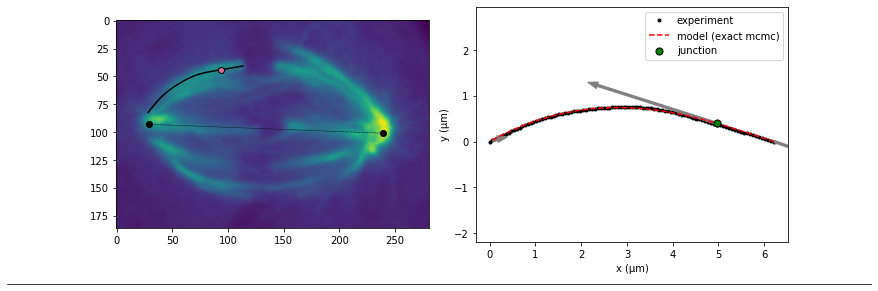

  0%|          | 48/10000 [00:00<00:42, 232.03it/s]

../../dat/WT unmanipulated k-fiber shapes/20171219_cell003/20171219_cell003_before_bridge_0.csv 0
20171219_cell003 0
Px =  0.1355741692888868
pole_left 16.766377403899746
P-K distance (L) =  8.12 um
Initial angle =  9.10 degrees


100%|██████████| 10000/10000 [00:34<00:00, 292.04it/s]


COMPARISON
0.020909892359539817 0.021529714403329375
Exact method error (mcmc): 0.0159


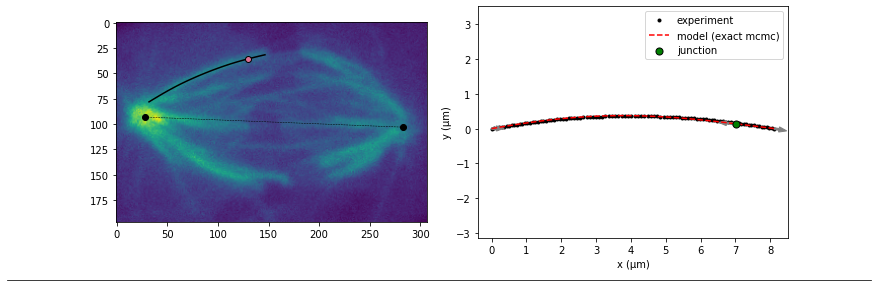

../../dat/WT unmanipulated k-fiber shapes/20180612_cell001/20180612_cell001_before_bridge_0.csv 0
20180612_cell001 0


  0%|          | 22/10000 [00:00<00:45, 219.18it/s]

Px =  0.11226621823477692
pole_left 14.806489286795841
P-K distance (L) =  7.85 um
Initial angle =  21.07 degrees


100%|██████████| 10000/10000 [00:38<00:00, 257.32it/s]


COMPARISON
0.06000252065602963 0.06472114320142186
Exact method error (mcmc): 0.0197


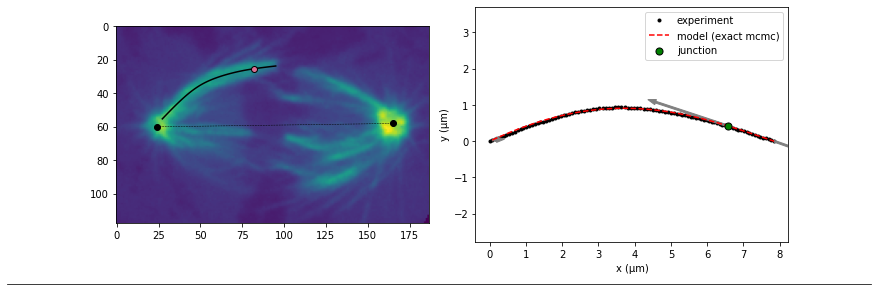

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 192/10000 [00:00<00:05, 1914.24it/s]

../../dat/WT unmanipulated k-fiber shapes/20180620_cell013/20180620_cell013_before_bridge_2.csv 2
20180620_cell013 2
Px =  0.2654102403671079
pole_right 14.625561527681594
P-K distance (L) =  6.07 um
Initial angle =  7.39 degrees


100%|██████████| 10000/10000 [00:05<00:00, 1879.21it/s]


COMPARISON
-0.026656868480293583 0.020302625519829212
Exact method error (mcmc): 0.1070


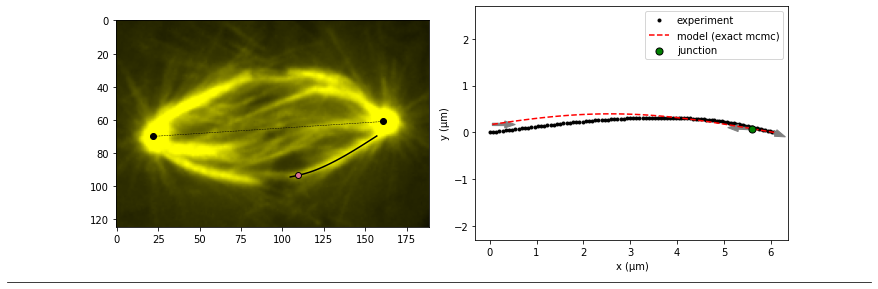

  0%|          | 45/10000 [00:00<00:46, 215.17it/s]

../../dat/WT unmanipulated k-fiber shapes/20180620_cell013/20180620_cell013_before_bridge_1.csv 1
20180620_cell013 1
Px =  0.038298436862251116
pole_left 14.625561527681594
P-K distance (L) =  6.28 um
Initial angle =  16.50 degrees


100%|██████████| 10000/10000 [00:41<00:00, 242.32it/s]


COMPARISON
0.1506964837455992 0.1502452817980351
Exact method error (mcmc): 0.0066


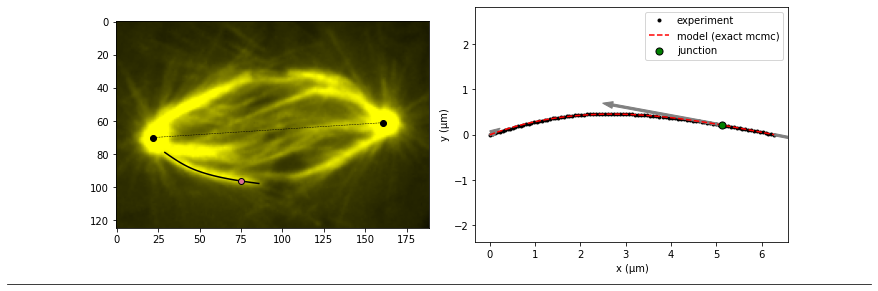

  0%|          | 29/10000 [00:00<01:11, 140.01it/s]

../../dat/WT unmanipulated k-fiber shapes/20180620_cell013/20180620_cell013_before_bridge_0.csv 0
20180620_cell013 0
Px =  0.16184471373953352
pole_left 14.625561527681594
P-K distance (L) =  5.89 um
Initial angle =  4.07 degrees


100%|██████████| 10000/10000 [00:44<00:00, 224.30it/s]


COMPARISON
0.03082693749007665 0.030802321584969428
Exact method error (mcmc): 0.0069


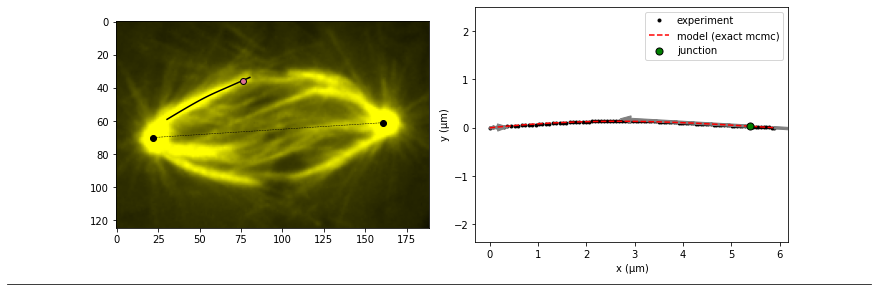

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 220/10000 [00:00<00:04, 2193.49it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell015/20180622_cell015_before_bridge_0.csv 0
20180622_cell015 0
Px =  -0.2634597228895078
pole_left 16.388411301892564
P-K distance (L) =  7.51 um
Initial angle =  18.18 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2229.32it/s]


COMPARISON
0.12671847889408763 -0.9847229481606743
Exact method error (mcmc): 1.1346


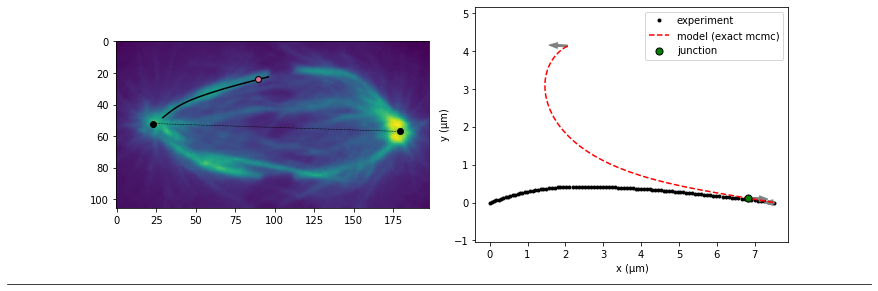

  0%|          | 46/10000 [00:00<00:45, 219.28it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell020/20180622_cell020_before_bridge_3.csv 3
20180622_cell020 3
Px =  0.1784240108050524
pole_right 12.401117893157858
P-K distance (L) =  5.47 um
Initial angle =  25.99 degrees


100%|██████████| 10000/10000 [00:43<00:00, 230.24it/s]


COMPARISON
0.13776094989314833 0.1393294723978764
Exact method error (mcmc): 0.0031


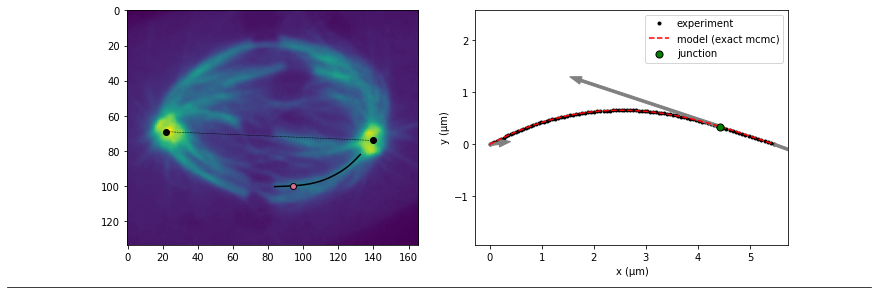

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 193/10000 [00:00<00:05, 1927.63it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell020/20180622_cell020_before_bridge_1.csv 1
20180622_cell020 1
Px =  0.23401001075929057
pole_right 12.401117893157858
P-K distance (L) =  6.03 um
Initial angle =  24.49 degrees


100%|██████████| 10000/10000 [00:05<00:00, 1829.45it/s]


COMPARISON
-0.01464855747306985 0.023405852161735588
Exact method error (mcmc): 0.3193


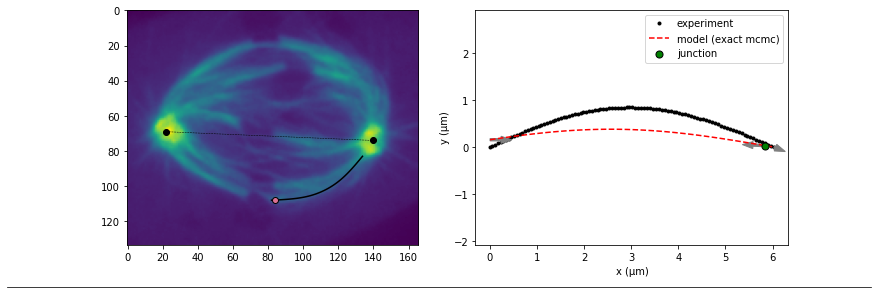

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 192/10000 [00:00<00:05, 1916.61it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell026/20180622_cell026_before_bridge_0.csv 0
20180622_cell026 0
Px =  -0.0703966622991541
pole_left 14.598398884809251
P-K distance (L) =  5.74 um
Initial angle =  24.35 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2074.12it/s]


COMPARISON
0.025306695002181526 -0.05791443470282405
Exact method error (mcmc): 0.4288


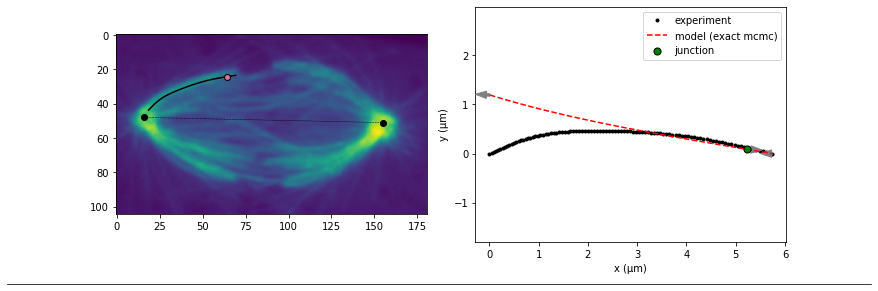

  0%|          | 47/10000 [00:00<00:45, 216.91it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell026/20180622_cell026_before_bridge_3.csv 3
20180622_cell026 3
Px =  0.1922109723678969
pole_right 14.598398884809251
P-K distance (L) =  6.13 um
Initial angle =  22.85 degrees


100%|██████████| 10000/10000 [00:42<00:00, 235.48it/s]


COMPARISON
0.06661865901155863 0.06841929924181045
Exact method error (mcmc): 0.0045


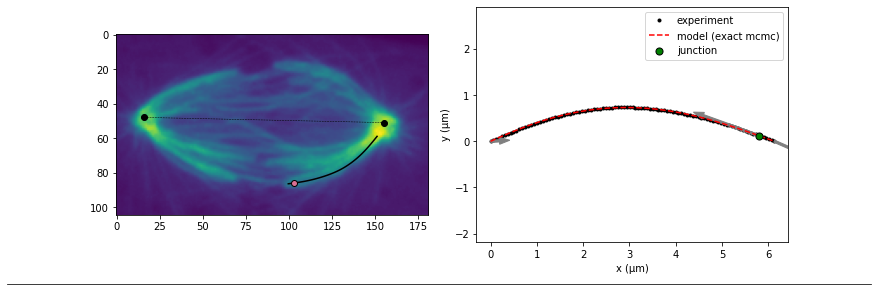

  0%|          | 20/10000 [00:00<00:50, 196.87it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell027/20180622_cell027_before_bridge_1.csv 1
20180622_cell027 1
Px =  0.20517265342616345
pole_left 14.181220857175873
P-K distance (L) =  5.44 um
Initial angle =  15.19 degrees


100%|██████████| 10000/10000 [00:42<00:00, 234.49it/s]


COMPARISON
0.06845015198954273 0.07227664776413417
Exact method error (mcmc): 0.0080


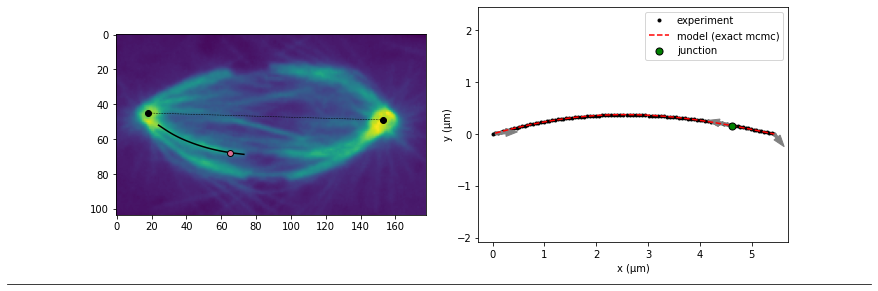

  0%|          | 19/10000 [00:00<00:53, 186.63it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell027/20180622_cell027_before_bridge_2.csv 2
20180622_cell027 2
Px =  0.16335547097834413
pole_left 14.181220857175873
P-K distance (L) =  6.23 um
Initial angle =  20.25 degrees


100%|██████████| 10000/10000 [00:48<00:00, 205.53it/s]


COMPARISON
0.0705261965210085 0.07480494866383669
Exact method error (mcmc): 0.0115


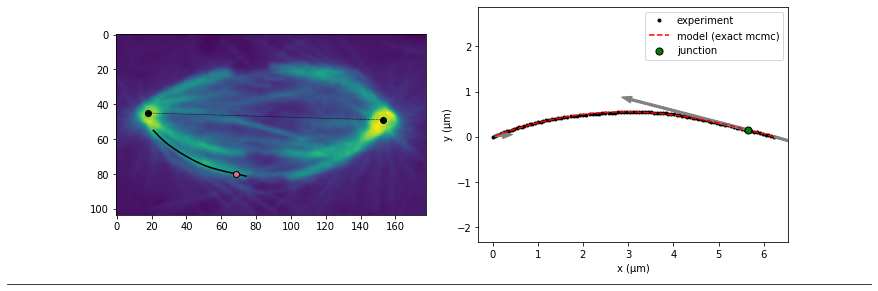

  0%|          | 19/10000 [00:00<00:54, 182.23it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell027/20180622_cell027_before_bridge_3.csv 3
20180622_cell027 3
Px =  0.06042514844448028
pole_right 14.181220857175873
P-K distance (L) =  6.82 um
Initial angle =  21.28 degrees


100%|██████████| 10000/10000 [00:45<00:00, 218.66it/s]


COMPARISON
0.15221838003364271 0.1523454093904295
Exact method error (mcmc): 0.0110


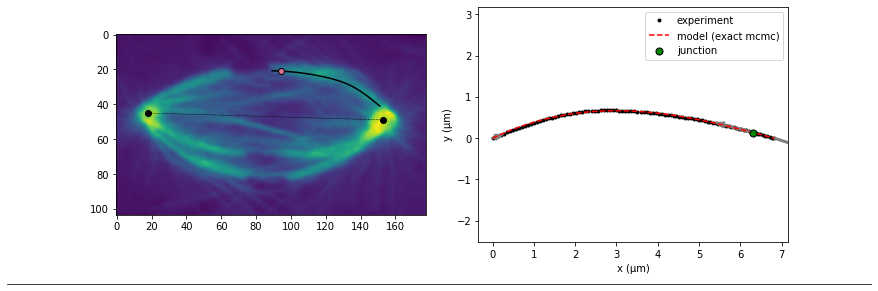

  0%|          | 20/10000 [00:00<00:51, 193.39it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell027/20180622_cell027_before_bridge_4.csv 4
20180622_cell027 4
Px =  0.25296841077483223
pole_right 14.181220857175873
P-K distance (L) =  5.78 um
Initial angle =  15.63 degrees


100%|██████████| 10000/10000 [00:38<00:00, 260.70it/s]


COMPARISON
0.05213197891485269 0.053610426121945554
Exact method error (mcmc): 0.0119


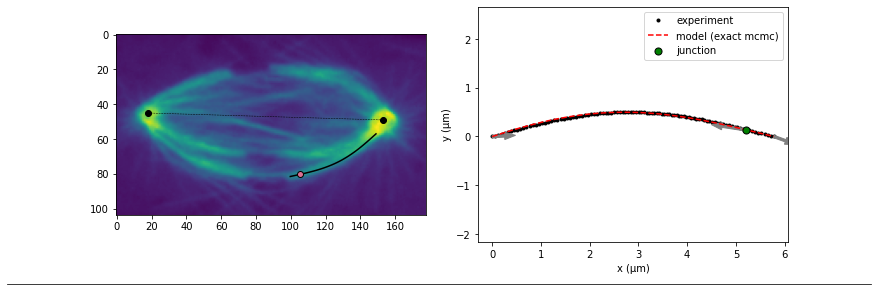

  0%|          | 20/10000 [00:00<00:50, 198.05it/s]

../../dat/WT unmanipulated k-fiber shapes/20180622_cell028/20180622_cell028_before_bridge_0.csv 0
20180622_cell028 0
Px =  0.10151399219474774
pole_left 16.907934527907305
P-K distance (L) =  7.63 um
Initial angle =  15.89 degrees


100%|██████████| 10000/10000 [00:41<00:00, 242.98it/s]


COMPARISON
0.06210411766726681 0.06267645091860707
Exact method error (mcmc): 0.0050


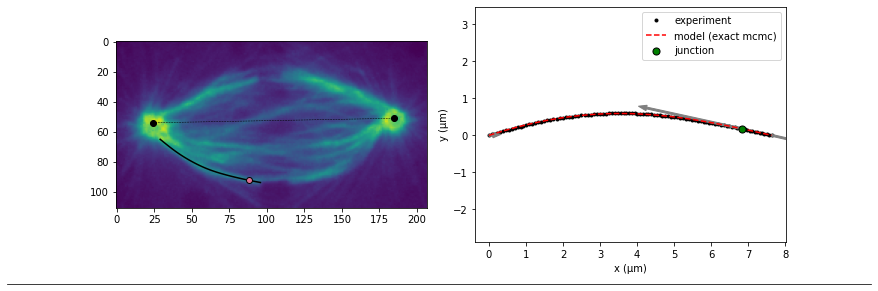

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 212/10000 [00:00<00:04, 2119.94it/s]

../../dat/WT unmanipulated k-fiber shapes/20180626_cell001/20180626_cell001_before_bridge_2.csv 2
20180626_cell001 2
Px =  -0.004585671806445172
pole_right 14.286175135423758
P-K distance (L) =  6.93 um
Initial angle =  31.42 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2127.01it/s]


COMPARISON
0.0013570789980356674 -0.004075152923804521
Exact method error (mcmc): 0.4024


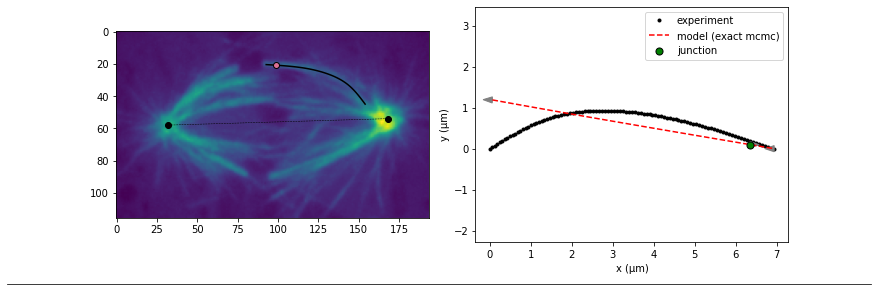

  0%|          | 19/10000 [00:00<00:52, 188.83it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell002/20180628_cell002_before_bridge_0.csv 0
20180628_cell002 0
Px =  0.14468668924959635
pole_left 13.236664987828316
P-K distance (L) =  7.16 um
Initial angle =  15.71 degrees


100%|██████████| 10000/10000 [00:39<00:00, 250.24it/s]


COMPARISON
0.04250657664842193 0.04303584323779486
Exact method error (mcmc): 0.0027


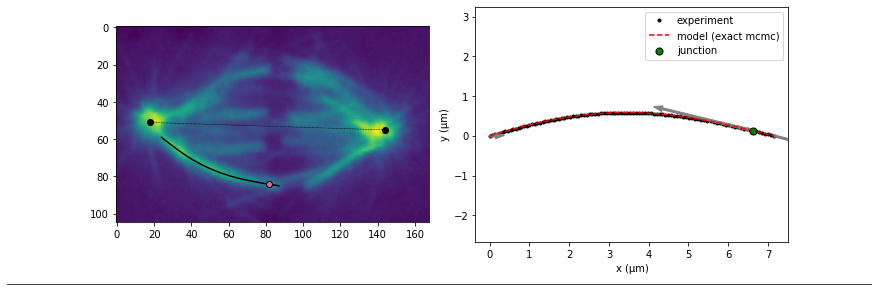

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 197/10000 [00:00<00:04, 1968.19it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell006/20180628_cell006_before_bridge_1.csv 1
20180628_cell006 1
Px =  -0.09280401500918303
pole_left 16.826557134482385
P-K distance (L) =  6.62 um
Initial angle =  30.69 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2107.10it/s]


COMPARISON
0.055268489787632005 -0.06209294988418643
Exact method error (mcmc): 0.4102


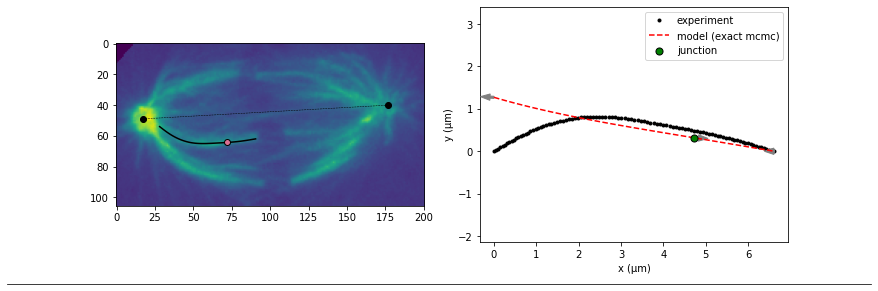

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 197/10000 [00:00<00:04, 1965.30it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell006/20180628_cell006_before_bridge_2.csv 2
20180628_cell006 2
Px =  -0.011340059124245816
pole_left 16.826557134482385
P-K distance (L) =  8.07 um
Initial angle =  33.12 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2071.24it/s]


COMPARISON
0.004787274160040126 -0.01172150548465985
Exact method error (mcmc): 0.4893


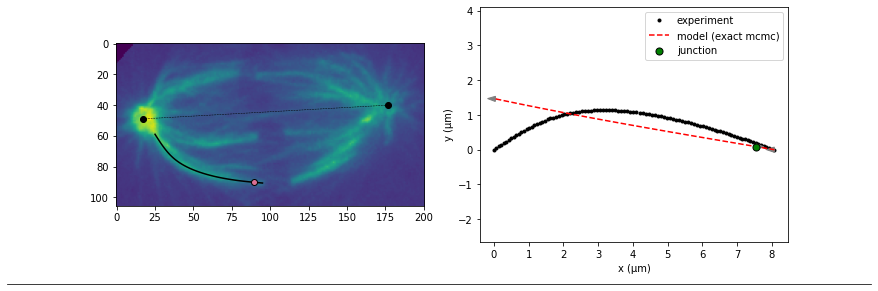

  0%|          | 40/10000 [00:00<00:52, 188.09it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell010/20180628_cell010_before_bridge_0.csv 0
20180628_cell010 0
Px =  0.2309690032186722
pole_left 12.8117211958425
P-K distance (L) =  5.65 um
Initial angle =  18.30 degrees


100%|██████████| 10000/10000 [00:40<00:00, 245.43it/s]


COMPARISON
0.0666315717960223 0.07262519604674278
Exact method error (mcmc): 0.0146


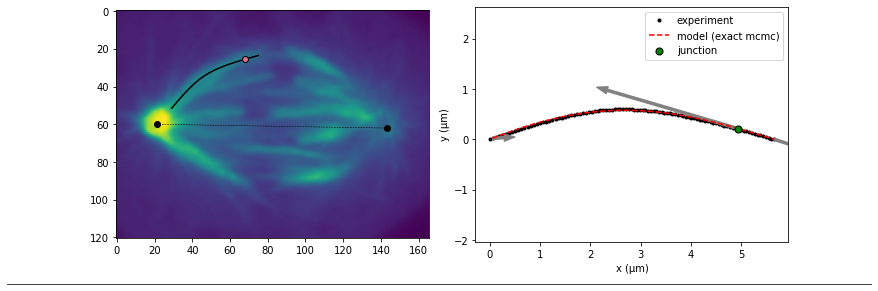

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 66/10000 [00:00<00:15, 646.43it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell010/20180628_cell010_before_bridge_2.csv 2
20180628_cell010 2
Px =  0.3402655341364106
pole_left 12.8117211958425
P-K distance (L) =  5.36 um
Initial angle =  10.08 degrees


100%|██████████| 10000/10000 [00:33<00:00, 295.77it/s]


COMPARISON
0.03938239572844522 0.0409264413989705
Exact method error (mcmc): 0.0214


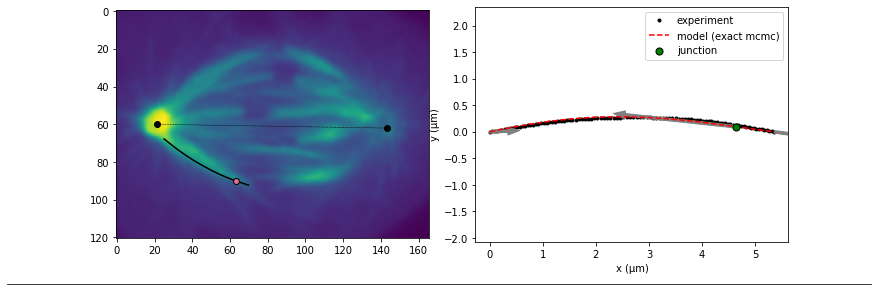

  0%|          | 16/10000 [00:00<01:02, 159.20it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell013/20180628_cell013_before_bridge_4.csv 4
20180628_cell013 4
Px =  0.08250385282558642
pole_right 15.015367128378845
P-K distance (L) =  6.37 um
Initial angle =  15.49 degrees


100%|██████████| 10000/10000 [00:42<00:00, 233.78it/s]


COMPARISON
0.09880552942380823 0.09972252263287595
Exact method error (mcmc): 0.0076


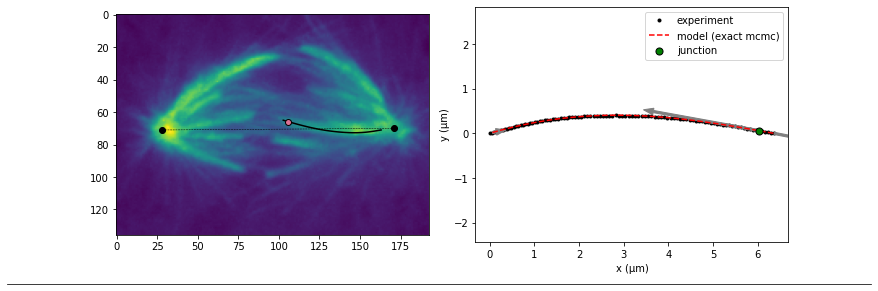

  0%|          | 20/10000 [00:00<00:52, 191.43it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell013/20180628_cell013_before_bridge_2.csv 2
20180628_cell013 2
Px =  0.16372914551324347
pole_left 15.015367128378845
P-K distance (L) =  4.54 um
Initial angle =  7.26 degrees


100%|██████████| 10000/10000 [00:41<00:00, 238.97it/s]


COMPARISON
0.08761532796423216 0.08724344185795307
Exact method error (mcmc): 0.0047


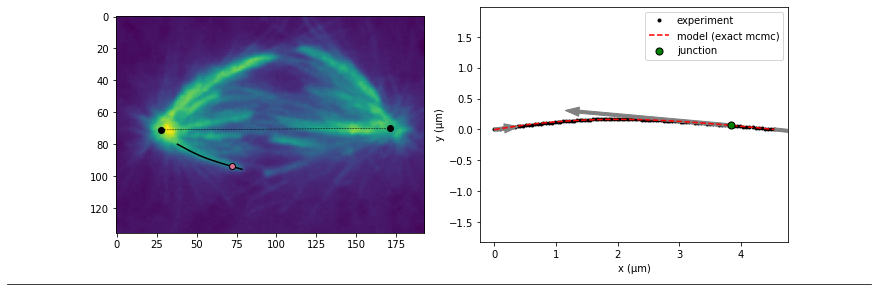

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 167/10000 [00:00<00:05, 1666.25it/s]

../../dat/WT unmanipulated k-fiber shapes/20180628_cell013/20180628_cell013_before_bridge_1.csv 1
20180628_cell013 1
Px =  0.6799979864124377
pole_left 15.015367128378845
P-K distance (L) =  3.82 um
Initial angle =  4.60 degrees


100%|██████████| 10000/10000 [00:05<00:00, 1756.36it/s]


COMPARISON
-0.0571019097523498 0.042216950898287725
Exact method error (mcmc): 0.1197


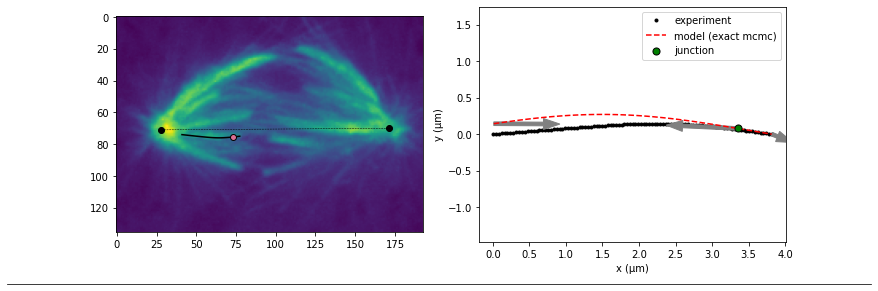

  0%|          | 21/10000 [00:00<00:49, 202.13it/s]

../../dat/WT unmanipulated k-fiber shapes/20180810_cell005/20180810_cell005_before_bridge_0.csv 0
20180810_cell005 0
Px =  0.24595359514731016
pole_left 14.527993667399501
P-K distance (L) =  5.53 um
Initial angle =  16.72 degrees


100%|██████████| 10000/10000 [00:39<00:00, 254.84it/s]


COMPARISON
0.057502554380997405 0.05897386714732411
Exact method error (mcmc): 0.0087


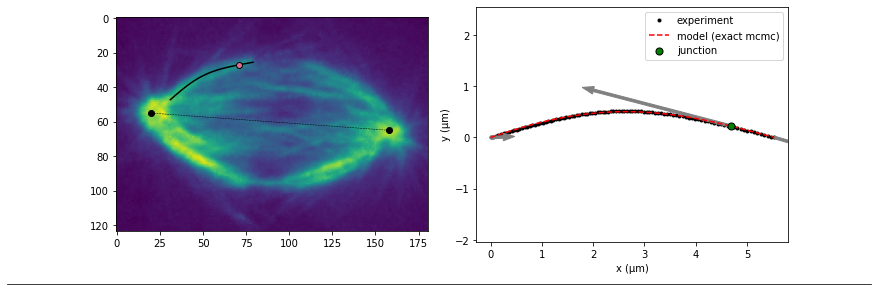

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 173/10000 [00:00<00:05, 1717.81it/s]

../../dat/WT unmanipulated k-fiber shapes/20180810_cell005/20180810_cell005_before_bridge_2.csv 2
20180810_cell005 2
Px =  0.266609116565817
pole_left 14.527993667399501
P-K distance (L) =  6.05 um
Initial angle =  11.13 degrees


100%|██████████| 10000/10000 [00:05<00:00, 1769.47it/s]


COMPARISON
-0.023079338870403143 0.01602255955819204
Exact method error (mcmc): 0.0616


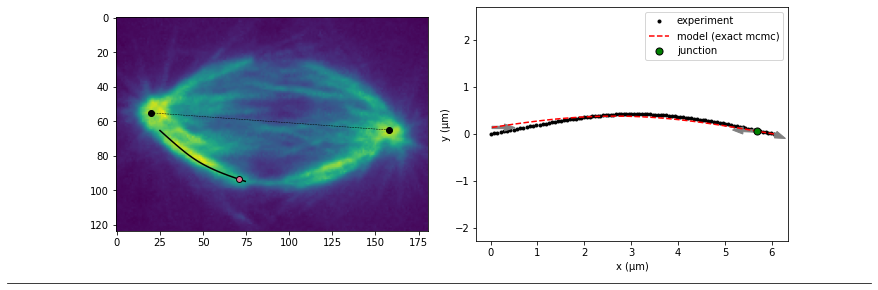

  0%|          | 20/10000 [00:00<00:49, 199.95it/s]

../../dat/WT unmanipulated k-fiber shapes/20180810_cell006/20180810_cell006_before_bridge_0.csv 0
20180810_cell006 0
Px =  0.18148503480295183
pole_left 16.811808350085364
P-K distance (L) =  5.45 um
Initial angle =  9.95 degrees


100%|██████████| 10000/10000 [00:41<00:00, 240.91it/s]


COMPARISON
0.04762962781749913 0.04999650118652424
Exact method error (mcmc): 0.0066


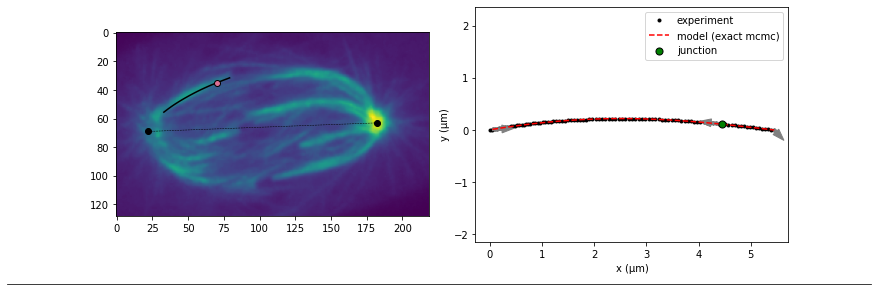

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 203/10000 [00:00<00:04, 2024.27it/s]

../../dat/WT unmanipulated k-fiber shapes/20180810_cell006/20180810_cell006_before_bridge_1.csv 1
20180810_cell006 1
Px =  -0.045270009794982476
pole_right 16.811808350085364
P-K distance (L) =  8.93 um
Initial angle =  28.80 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2018.88it/s]


COMPARISON
0.023737033733064263 -0.07255250195894553
Exact method error (mcmc): 0.6564


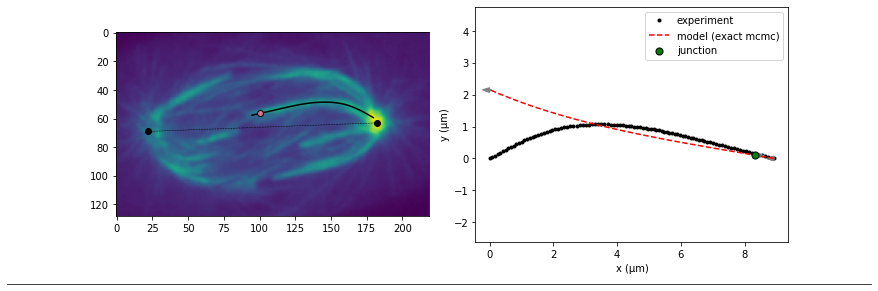

  0%|          | 20/10000 [00:00<00:51, 193.15it/s]

../../dat/WT unmanipulated k-fiber shapes/20210526_cell001/20210526_cell001_before_bridge_3.csv 3
20210526_cell001 3
Px =  0.13476974506577136
pole_left 13.074465074334782
P-K distance (L) =  8.43 um
Initial angle =  15.17 degrees


100%|██████████| 10000/10000 [00:36<00:00, 270.54it/s]


COMPARISON
0.04120401507350967 0.04270683711588874
Exact method error (mcmc): 0.0600


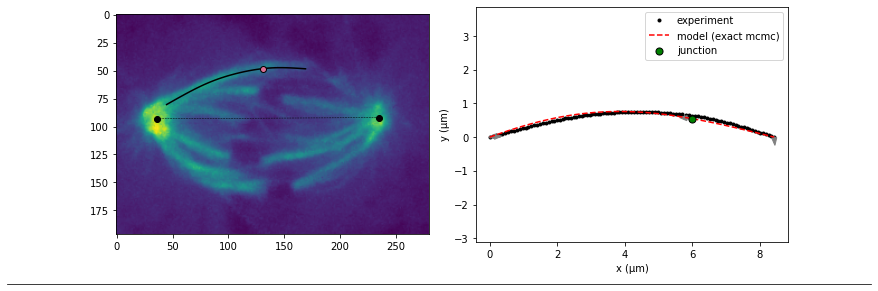

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 210/10000 [00:00<00:04, 2097.12it/s]

../../dat/WT unmanipulated k-fiber shapes/20210526_cell001/20210526_cell001_before_bridge_2.csv 2
20210526_cell001 2
Px =  -0.08732979030545594
pole_right 13.074465074334782
P-K distance (L) =  5.61 um
Initial angle =  16.00 degrees


100%|██████████| 10000/10000 [00:04<00:00, 2092.26it/s]


COMPARISON
0.03008714583980246 -0.07571283886904223
Exact method error (mcmc): 0.4613


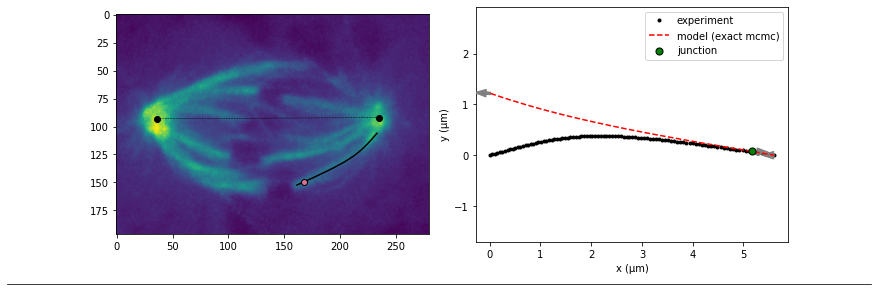

  0%|          | 19/10000 [00:00<00:54, 184.49it/s]

../../dat/WT unmanipulated k-fiber shapes/20210526_cell007/20210526_cell007_before_bridge_2.csv 2
20210526_cell007 2
Px =  0.21539219753529512
pole_right 16.44089171213046
P-K distance (L) =  5.54 um
Initial angle =  17.35 degrees


100%|██████████| 10000/10000 [00:42<00:00, 237.34it/s]


COMPARISON
0.0767810668630735 0.0773919787459808
Exact method error (mcmc): 0.0023


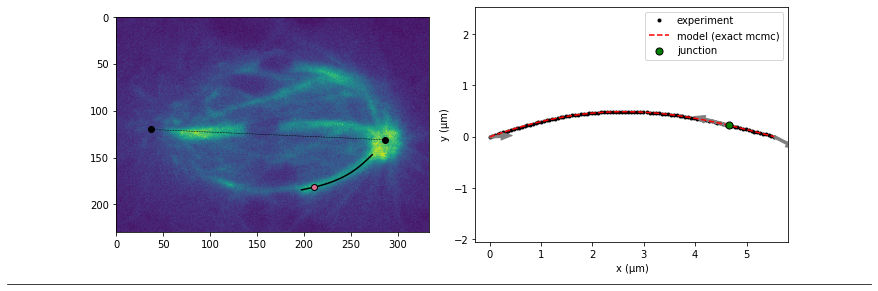

In [46]:
np.random.seed(0)

M0_zero = True
flip = True

df_coarsegrain = pd.read_pickle("noforce_Fx_Fy_Mp.pkl")
df_fin = pd.DataFrame()

for cell in cells:
    spindle = cell.split("/")[-1].split(".")[0]
    image = mpimg.imread("%s/%s_before.tif"%(cell,spindle))
    profiles = sorted(list(set(glob.glob("%s/*.csv"%cell)) - set(glob.glob("%s/*poles.csv"%cell)) - set(glob.glob("%s/*bridge*.csv"%cell))))
    pole_csv = glob.glob("%s/*poles.csv"%cell)[-1]
    bridge_csv_ls = glob.glob("%s/*bridge*.csv"%cell)
    
    if len(bridge_csv_ls) > 0:
        for bridge_csv in bridge_csv_ls: 
            kfiber_number = bridge_csv.split("/")[-1].split(".")[0].split("_")[-1]
            print(bridge_csv,kfiber_number)
            for profile in profiles:
                if profile.split("/")[-1].split(".")[0].split("_")[-1] == bridge_csv.split("/")[-1].split(".")[0].split("_")[-1]:
                    print(spindle, kfiber_number)
                    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

                    Px = df_coarsegrain.loc[(df_coarsegrain["Spindle"] == spindle) & (df_coarsegrain["Kfiber"] == kfiber_number)]["Rx (mcmc)"].values[0]                    # Raw data input
                    print("Px = ", Px)
                    df_bridge = pd.read_csv(bridge_csv)
                    df_pole = pd.read_csv(pole_csv)
                    df_profile = pd.read_csv(profile)

                    x_dat = np.array(df_profile["X"].values)
                    y_dat = np.array(df_profile["Y"].values)

                    # Show the spindle image & overlaid k-fiber profile
                    ax[0].imshow(image)
                    ax[0].plot(x_dat, y_dat, color = 'k')

                    x_bridge = np.array(df_bridge["X"].values)[0]
                    y_bridge = np.array(df_bridge["Y"].values)[0]
                    res, indices = distances_pair_min(np.array([x_bridge]), np.array([y_bridge]),x_dat, y_dat)
                    x_bridge, y_bridge = x_dat[int(indices[0])], y_dat[int(indices[0])]
                    
                    ax[0].scatter(x_bridge, y_bridge, color='palevioletred', edgecolor='k', zorder=10)

                    # Pole coordinates & plotting
                    P1x = np.array(df_pole["X"].values)[0]
                    P1y = np.array(df_pole["Y"].values)[0]
                    P2x = np.array(df_pole["X"].values)[1]
                    P2y = np.array(df_pole["Y"].values)[1]
                    ax[0].scatter([P1x, P2x], [P1y, P2y], color='k')
                    ax[0].plot([P1x, P2x], [P1y, P2y], color='k', ls='--', lw=0.5)                    
                    
                    # Angle that the pole-kinetochore line
                    # forms with the pole-pole axis
                    PP_vector = [P2x-P1x, P2y-P1y]
                    K_vector = [x_dat[-1]-x_dat[0], y_dat[-1]-y_dat[0]]
                    unit_PP_vector = PP_vector / np.linalg.norm(PP_vector)
                    unit_K_vector = K_vector / np.linalg.norm(K_vector)
                    dot_product = np.dot(unit_PP_vector, unit_K_vector)
                    PP_K_angle = np.arccos(dot_product)
                    if PP_K_angle > np.pi/2:
                        PP_K_angle = np.pi - PP_K_angle

                    # Identify the spindle side in which the k-fiber lies
                    x_mean = np.mean(x_dat)
                    y_mean = np.mean(y_dat)
                    dist_P1 = np.sqrt((x_mean-P1x)**2 + (y_mean-P1y)**2)
                    dist_P2 = np.sqrt((x_mean-P2x)**2 + (y_mean-P2y)**2)
                    if dist_P2 < dist_P1:
                        pole = "pole_right"
                        x_dat = -x_dat
                        x_bridge = -x_bridge
                    else:
                        pole = "pole_left"

                    # Rotate to have the end-points at y=0
                    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
                    x_dat, y_dat = rotate(x_dat, y_dat, angle)
                    x_bridge, y_bridge = rotate(x_bridge, y_bridge, angle)

                    # Translation to start at origin
                    x_bridge -= x_dat[0]
                    y_bridge -= y_dat[0]
                    x_dat -= x_dat[0]
                    y_dat -= y_dat[0]

                    # Flipping to ensure a positive initial slope
                    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
                    if theta0 < 0.0:
                        y_bridge = -y_bridge
                        y_dat = -y_dat
                        angle = -angle
                        
                    # Convert from pixel to micron units based on scope camera calibration
                    is_2017 = re.search('2017',cell.split("/")[-1])
                    is_2021 = re.search('2021',cell.split("/")[-1])
                    if is_2017:
                        scope_calibration = 0.0657
                    elif is_2021:
                        scope_calibration = 0.0657
                    else:
                        scope_calibration = 0.105

                    x_dat = x_dat*scope_calibration
                    y_dat = y_dat*scope_calibration
                    xj = x_bridge*scope_calibration
                    
                    # Pole-kinetochore (P-K) distance
                    L = x_dat[-1] - x_dat[0]

                    ## pole-pole distance
                    PP_dist = np.sqrt((P2y-P1y)**2+(P2x-P1x)**2) * scope_calibration

                    # Initial angle in the rotated profile
                    theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

                    if show_details:
                        print(pole,PP_dist)
                        print("P-K distance (L) =  %.2f um" % L)
                        print("Initial angle =  %.2f degrees" % np.degrees(theta_init))


                    if flip:
                        # Flip the profile
                        x_dat = L - x_dat
                        xj = L - xj
                        x_dat = np.flip(x_dat)
                        y_dat = np.flip(y_dat)
                        


                    # ----------------- Parameter inference: Large angle (MCMC) ----------------- #


#                     p_init = np.array([-0.05, 0, -0.01, np.radians(10), 0.01])
#                     p_init = np.array([-0.1*Px, 0, -0.01, np.radians(10), 0.01])
                    p_init = np.array([-0.1*Px, 0, -0.05*Px, np.radians(10), 0.05*Px])
                    p_init_mat = np.tile(p_init, (n_walkers, 1))

                    args = (x_dat, y_dat, Px, L, xj, M0_zero, end_to_end)
                    sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)

                    p_opt_mat = p_init_mat
                    
                    np.random.seed(0)
                    for j in range(n_dim):
                        p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
                        p_opt_mat[:,j] += np.random.normal(1e-4, 1e-5, n_walkers)
                    for n in range(n_walkers):
                        if p_opt_mat[n,1] < 0:
                            p_opt_mat[n,1] = np.abs(np.random.normal(0, 1e-5))
                        if p_opt_mat[n,1] - p_opt_mat[n,2]*L < 0:
                            p_opt_mat[n,2] = np.abs(np.random.normal(0, 1e-7))

                    _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)

                    df_mcmc = sampler_to_dataframe(sampler, columns=cols)
                    p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]

                    # Enforce Mk = 0
                    p_opt_mcmc[1] = 0


                    Rx_opt_mcmc, M0_opt_mcmc, Ry_opt_mcmc, theta0_opt_mcmc, Jy_opt_mcmc = p_opt_mcmc

                    res = res_fn_exact(p_opt_mcmc, x_dat, y_dat, Px, L, xj, M0_zero=M0_zero)

                    x_mcmc, y_mcmc, M_mcmc, yj = deflection_exact(p_opt_mcmc, x_dat, y_dat, Px, L, xj)

                    y_mcmc = y_mcmc[x_mcmc <= L]
                    M_mcmc = M_mcmc[x_mcmc <= L]
                    x_mcmc = x_mcmc[x_mcmc <= L]

                    if flip:
                        x_mcmc = L - x_mcmc
                        x_mcmc = np.flip(x_mcmc)
                        y_mcmc = np.flip(y_mcmc)

                        x_dat = L - x_dat
                        x_dat = np.flip(x_dat)
                        y_dat = np.flip(y_dat)


                        xj = L - xj

                        Kx = -p_opt_mcmc[0]
                        Ky = p_opt_mcmc[2]

                        Jx = - Px - Kx
                        Jy = p_opt_mcmc[-1]

                        Py = -(Ky+Jy)

                        Mj = Jy*(L-xj) + Jx*yj
                        M0 = Py*L + Mj
                        
                        print('COMPARISON')
                        print(M0, M_mcmc[-1])
                        
        

                    # --------- Error metrics --------- #
                    res_mcmc = distances_pair_min_new(x_dat, y_dat, x_mcmc, y_mcmc)
                    err_mcmc = np.sqrt(np.mean(res_mcmc**2))

                    if show_details:
                        print("Exact method error (mcmc): %.4f"%err_mcmc)


                    df_fin = df_fin.append({'Spindle': spindle,
                                            'Kfiber': kfiber_number,
                                            'PP distance': PP_dist,
                                            'Pole': pole, 
                                            'PP-K angle (deg)': np.degrees(PP_K_angle), 
                                            'x_dat': x_dat,
                                            'y_dat': y_dat,
                                            'Px (input)': Px,
                                            'xj': xj,
                                            'yj': yj,
                                            'L': L,
                                            'x (mcmc)': x_mcmc,
                                            'y (mcmc)': y_mcmc,
                                            'M0 (mcmc)': M0,
                                            'Py (mcmc)': Py,
                                            'Kx (mcmc)': Kx,
                                            'Ky (mcmc)': Ky,
                                            'Jx (mcmc)': Jx,
                                            'Jy (mcmc)': Jy,
                                            'theta0 (mcmc)': theta0_opt_mcmc,
                                            'RMSE (mcmc)': err_mcmc}, ignore_index=True)


                    ax[1].plot(x_dat, y_dat, '.', color = 'k', lw = 2, label = 'experiment', zorder=2)
                    ax[1].scatter(xj, yj, s=50, color = 'green', edgecolor='k', label = 'junction', zorder=30)
                    ax[1].plot(x_mcmc, y_mcmc, '--', color = 'red', label = 'model (exact mcmc)', zorder=20)

                    plt.arrow(x_mcmc[0],y_mcmc[0], Px, Py, width=0.05, color='grey', zorder=5)
                    plt.arrow(xj, yj, Jx, Jy, width=0.05, color='grey', zorder=5)
                    plt.arrow(x_mcmc[-1],y_mcmc[-1], Kx, Ky, width=0.05, color='grey', zorder=5)
                    
                    ax[1].legend()
                    ax[1].set_xlabel('x (μm)')
                    ax[1].set_ylabel('y (μm)')
                    ax[1].axis('equal')

                    plt.tight_layout()
                    line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
                    fig.add_artist(line)

                    plt.show()

pkl_name = 'noforce_junction_fixedPx.pkl'
df_fin.to_pickle(pkl_name)

In [34]:
pkl_name = 'noforce_junction.pkl'
df_fin.to_pickle(pkl_name)